# Working with raw DICOM

## Imports

In [ ]:
import os
import pydicom
import subprocess
from pathlib import Path
import nibabel as nib
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import matplotlib.pyplot as plt
import numpy as np

## Just checking stuff in the raw DICOM folder

In [3]:
dicom_dir = "V:/Common/Staff Personal Folders/DanielH/TractographyPatient/09733981"
SeriesDescriptions = []
b_vals = []

for fname in os.listdir(dicom_dir):
    try:
        path = os.path.join(dicom_dir, fname)
        ds = pydicom.dcmread(path, stop_before_pixels=True)
        print("File:", fname)
        print("  Modality:", ds.get("Modality", "N/A"))
        print("  SeriesDescription:", ds.get("SeriesDescription", "N/A"))
        if ds.get("Modality", "N/A") == "MR" and ds.get("SeriesDescription", "N/A") not in SeriesDescriptions:
            SeriesDescriptions.append(ds.get("SeriesDescription", "N/A"))

        if ds.get("Modality", "N/A") == "MR" and ds.get((0x0018, 0x9087), "N/A") not in b_vals:
            b_vals.append(ds.get((0x0018, 0x9087), "N/A"))
            
        print("  ProtocolName:", ds.get("ProtocolName", "N/A"))
        print("  Manufacturer:", ds.get("Manufacturer", "N/A"))
        print("  b-value:", ds.get((0x0018, 0x9087), "N/A"))  # Diffusion b-value tag
        print()
    except Exception as e:
        print(f"Could not read {fname}: {e}")

Could not read MR_1.3.12.2.1107.5.2.32.35382.2018032511315897853549241.0.0.0.dir: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Could not read MR_1.3.12.2.1107.5.2.32.35382.2018032511330054146649846: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Could not read MR_1.3.12.2.1107.5.2.32.35382.2018032511330088221449851: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Could not read MR_1.3.12.2.1107.5.2.32.35382.2018032511330118592549865: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Could not read MR_1.3.12.2.1107.5.2.32.35382.2018032511330132271549870: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header

## Trying to convert folder to NIfTI

In [ ]:
dicom_dir = Path("V:/Common/Staff Personal Folders/DanielH/TractographyPatient/09733981")
nifti_dir = Path("V:/Common/Staff Personal Folders/DanielH/TractographyPatient/09733981_NIfTI")

nifti_dir.mkdir(parents=True, exist_ok=True) # make folder for NIFTI if it doesnt exist yet

cmd = [
    "dcm2niix",
    "-z", "y",
    "-f", "%p_%s",
    "-o", str(nifti_dir),
    str(dicom_dir)
]

subprocess.run(cmd, check=True)

## Doing stuff with NIfTI folder with DiPy

### Extracting data

In [3]:
nifti_file = "V:/Common/Staff Personal Folders/DanielH/TractographyPatient/09733981_NIfTI/ep2d_diff_mddw_ISO_1.5MM_2.nii.gz"
bval_file  = "V:/Common/Staff Personal Folders/DanielH/TractographyPatient/09733981_NIfTI/ep2d_diff_mddw_ISO_1.5MM_2.bval"
bvec_file  = "V:/Common/Staff Personal Folders/DanielH/TractographyPatient/09733981_NIfTI/ep2d_diff_mddw_ISO_1.5MM_2.bvec"

# Load data
img = nib.load(nifti_file)
data = img.get_fdata()
affine = img.affine
bvals, bvecs = read_bvals_bvecs(bval_file, bvec_file)

print("Shape:", data.shape)

Shape: (256, 256, 72, 20)


### Plotting slice

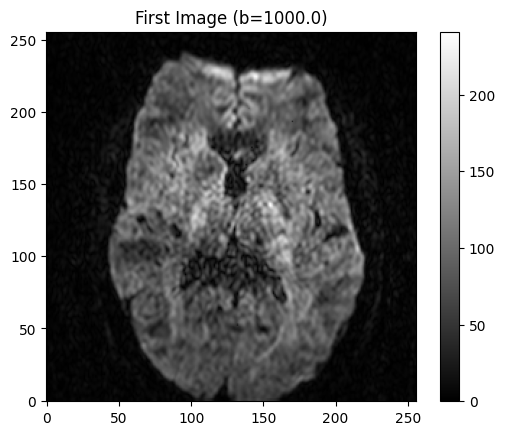

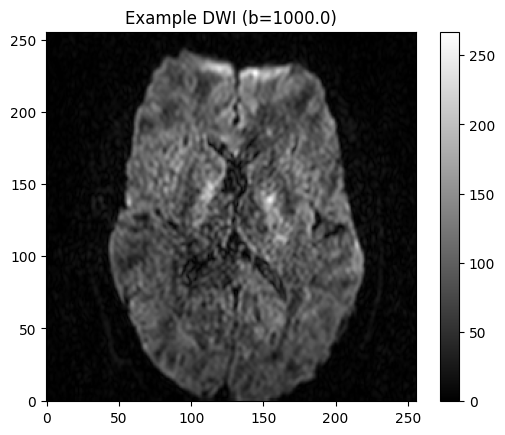

In [4]:
# Choose one slice from the middle
slice_index = data.shape[2] // 2
bval_index = data.shape[3] // 2

# Show the S0 (usually volume 0)
plt.imshow(data[:, :, slice_index, 0].T, cmap="gray", origin="lower")
plt.title(f"First Image (b={bvals[0]})")
plt.colorbar()
plt.show()

# Show one of the DWIs
plt.imshow(data[:, :, slice_index, bval_index].T, cmap="gray", origin="lower")
plt.title(f"Example DWI (b={bvals[bval_index]})")
plt.colorbar()
plt.show()

### ADC Map... can't do it cuz no S=0 value

### Basic tractography (same one as dipy tutorial)